# **Projeto Final - Noções de Inteligência Artificial 2025/1**
## **Alunos**:
- Caio Medeiros Balaniuk (matrícula: 231025190)
- Davi Henrique Vieira Lima (matrícula: 231013529)
- Gabriel Caixeta Romero (matrícula: 232036896)
- Vitor Amorim Mello (matrícula: 231037048)


# **1. Instalação da Biblioteca D2L**
A biblioteca `D2L` (**Dive Into Deep Learning**) é necessária ser instalada para permitir:
  *  Utilitários prontos para carregar e visualizar datasets como MNIST, Fashion-MNIST, entre outros.
  *  Funções auxiliares para construir, treinar e avaliar redes neurais em PyTorch.
  *  Classes úteis como `DataModule`, `Trainer`, `Classifier`, entre outras, que facilitam o desenvolvimento e experimentação com redes neurais.

In [1]:
!pip install d2l

# **2. Importação de Bibliotecas**
Para permitir o desenvolvimento do trabalho, é necessário a importação das seguintes bibliotecas:
  * `pandas`: principal biblioteca para **manipulação e análise de dados tabulares** (DataFrames).
  * `os`: biblioteca para **interagir com o sistema operacional**, útil para manipulação de arquivos e diretórios.
  * `gdown`: biblioteca utilizada para **fazer download de arquivos diretamente do Google Drive**, facilitando o carregamento de datasets.
  * `zipfile`: módulo padrão do Python para **descompactar arquivos .zip**, usado quando o dataset vem comprimido.
  * `torch`: principal biblioteca de **machine learning com PyTorch**.
  * `torch from d2l`: apresenta utilitários da biblioteca **Dive into Deep Learning (d2l)** para PyTorch.
  * `nn from torch`: módulo de **redes neurais (neural networks)** do PyTorch.
  * `train_test_split from sklearn.model_selection`: função para **dividir os dados em conjuntos de treino e teste**, importante para validação do modelo.
  * `StandardScaler from sklearn.preprocessing`: usada para **normalizar características numéricas**, garantindo que cada feature tenha média 0 e desvio padrão 1.
  * `matplotlib.pyplot`: permite a visualização gráfica do **Matplotlib**.

In [2]:
import pandas as pd
import os
import gdown
import zipfile
import torch
from d2l import torch as d2l
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# **3. Dataset**

## **3.1. Tabela FIPE**
O dataset utilizado neste trabalho é composto por dados extraídos da **Tabela Fipe**, que é uma referência oficial no Brasil para a **avaliação de preços médios de veículos automotores** (carros, motos e caminhões).

A **Tabela Fipe** é elaborada pela **Fundação Instituto de Pesquisas Econômicas (FIPE)** e fornece mensalmente o **preço médio praticado no mercado nacional para veículos novos e usados**.

Cada registro da Tabela Fipe geralmente contém informações como:
* **Marca do veículo** (ex: Fiat, Honda, Toyota),

* **Modelo do veículo** (ex: Palio 1.0, Civic EXL),

* **Ano de fabricação** (anomod),

* **Combustível utilizado** (ex: Gasolina, Flex, Diesel),

* **Mês/Ano de referência da cotação** (mesref / anoref),

* **Valor de mercado estimado** (em reais).

## **3.2. Extração e Organização do Dataset**
O conjunto de dados foi gerado utilizando um **web crawler** disponível no repositório [fipe-crawler](https://github.com/rafaelgou/fipe-crawler.git), que automatiza a coleta da Tabela Fipe diretamente do site oficial.

Foram coletadas informações dos **últimos 12 meses**, organizadas em múltiplos arquivos CSV (um para cada mês), contendo milhares de registros.

Esses arquivos foram agrupados em um **arquivo `.zip` hospedado no Google Drive**, sendo baixados e descompactados automaticamente pelo seguinte trecho de código:

In [3]:
# Baixar o arquivo zip do Google Drive
url = "https://drive.google.com/uc?id=125NtHsqQaokd76-ThXVmQLvLy1vXVd56"
output = "fipe_dataset.zip"
gdown.download(url, output, quiet=False)

# Descompactar
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("fipe_dataset_extracted")

# Caminho da pasta
caminho_pasta = "/content/fipe_dataset_extracted/dataset"


Downloading...
From: https://drive.google.com/uc?id=125NtHsqQaokd76-ThXVmQLvLy1vXVd56
To: /content/fipe_dataset.zip
100%|██████████| 187k/187k [00:00<00:00, 62.3MB/s]


## **3.3. Leitura e Pré-processamento Inicial dos Dados**

Nesta etapa, realizamos a leitura dos arquivos `.csv` extraídos do arquivo `.zip` contendo os dados mensais da Tabela Fipe.

Etapas do processo:

1. **Listagem dos Arquivos:** Todos os arquivos dentro do diretório da base são listados e ordenados alfabeticamente para garantir consistência na leitura.

2. **Leitura de Cada Arquivo CSV:** Cada arquivo `.csv` é lido individualmente utilizando o `pandas.read_csv`. Caso haja erro na leitura de algum arquivo (ex: linhas mal formatadas), ele será ignorado com a opção `on_bad_lines="skip"`.

3. **Concatenação dos Dados:** Todos os DataFrames lidos são concatenados em um único DataFrame chamado `dados`, unificando todos os registros coletados ao longo dos meses.

4. **Criação da Coluna `timeprod`:** Essa coluna representa o tempo de produção do veículo (em meses) desde seu ano de fabricação (`anomod`) até o ano e mês de referência (`anoref`, `mesref`).

5. **Seleção de Colunas Relevantes:** Apenas as colunas de interesse são mantidas para a análise: marca, modelo, ano de fabricação, tipo de combustível, tempo de produção e valor.

6. **Filtragem de Registros com Valores Realistas:** São removidos registros com anos ou tempos de produção considerados fora do intervalo aceitável (anomalias ou erros de coleta).

7. **Remoção de Duplicatas:** Garante que não haja linhas repetidas no conjunto final.

8. **Exibição Final:** Apresenta o DataFrame resultante com os dados prontos para o pré-processamento posterior e uso em modelos de aprendizado de máquina.



In [4]:
arquivos = sorted(os.listdir(caminho_pasta))

dfs = []

for arquivo in arquivos:
    caminho_arquivo = os.path.join(caminho_pasta, arquivo)
    try:
        df = pd.read_csv(caminho_arquivo, engine="python", on_bad_lines="skip")
        dfs.append(df)
    except Exception as e:
        print(f"Erro ao ler {arquivo}: {e}")

dados = pd.concat(dfs, ignore_index=True)

dados["timeprod"] = (dados["anoref"] - dados["anomod"]) * 12 + (dados["mesref"] - 1)

dados_final = dados[["marca", "modelo", "anomod", "comb", "timeprod", "valor"]]

dados_filtrados = dados_final[
    (dados_final["anomod"] >= 1980) & (dados_final["anomod"] <= 2025) &
    (dados_final["timeprod"] >= 0) & (dados_final["timeprod"] <= 600)
]

dt = dados_filtrados.drop_duplicates()

print(dt)

                marca                                    modelo  anomod  \
0                Audi  A4 2.0 Avant Ambie. 2.0 16V TFSi S tron.    2018   
1                Audi  A4 2.0 Avant Ambie. 2.0 16V TFSi S tron.    2017   
2                Audi                           A4 2.8 30V Mec.    2001   
3                Audi           A4 3.0 30V 218cv Multitronic 4p    2006   
4                Audi           A4 3.0 30V 218cv Multitronic 4p    2004   
...               ...                                       ...     ...   
9351  VW - VolksWagen      VOYAGE TREND 1.6 Mi Total Flex 8V 4p    2009   
9353             Wake                Way 1.6 Total Flex 8V Mec.    2016   
9354             Wake                Way 1.6 Total Flex 8V Mec.    2012   
9355             Wake                Way 1.6 Total Flex 8V Mec.    2010   
9356             Wake                Way 1.8 Total Flex 8V Mec.    2010   

          comb  timeprod   valor  
0     Gasolina        81  144961  
1     Gasolina        93  139

In [5]:
# 1. Separar features (X) e alvo (y)
df = dt.dropna()
X = df.drop('valor', axis=1)
y = df['valor']

# 2. Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Pré-processamento dos dados
categorical_features = ['marca', 'modelo', 'comb']
numerical_features = ['anomod', 'timeprod']

# --- Processando os dados de TREINO ---
scaler = StandardScaler()
X_train_numerical_scaled = scaler.fit_transform(X_train[numerical_features])
X_train_numerical = pd.DataFrame(X_train_numerical_scaled, columns=numerical_features, index=X_train.index)
X_train_categorical = pd.get_dummies(X_train[categorical_features], drop_first=True)
X_train_processed = pd.concat([X_train_numerical, X_train_categorical], axis=1)

# --- Processando os dados de TESTE ---
X_test_numerical_scaled = scaler.transform(X_test[numerical_features])
X_test_numerical = pd.DataFrame(X_test_numerical_scaled, columns=numerical_features, index=X_test.index)
X_test_categorical = pd.get_dummies(X_test[categorical_features], drop_first=True)
X_test_processed = pd.concat([X_test_numerical, X_test_categorical], axis=1)


X_test_processed = X_test_processed.reindex(columns=X_train_processed.columns, fill_value=0)

# 4. Conversão para Tensores PyTorch

# FORÇA a conversão de todos os dados para float32 ANTES de criar o tensor.
# Isso resolve o problema de conversão do NumPy.
# Usamos .to_numpy() que é a forma moderna e recomendada no lugar de .values
X_train_tensor = torch.tensor(X_train_processed.astype('float32').to_numpy())
y_train_tensor = torch.tensor(y_train.astype('float32').to_numpy()).view(-1, 1)

X_test_tensor = torch.tensor(X_test_processed.astype('float32').to_numpy())
y_test_tensor = torch.tensor(y_test.astype('float32').to_numpy()).view(-1, 1)

print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([7278, 3369])
torch.Size([7278, 1])
torch.Size([1820, 3369])
torch.Size([1820, 1])


# **4. Modelos**

In [6]:
class LinearRegression(d2l.Module):
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

In [7]:
@d2l.add_to_class(LinearRegression)
def forward(self, X):
    return self.net(X)

In [8]:
@d2l.add_to_class(LinearRegression)
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

In [9]:
@d2l.add_to_class(LinearRegression)
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

# **5.Treino**


In [11]:
#instanciando o modelo
from d2l import torch as d2l

# Cria o modelo com taxa de aprendizado (por exemplo, 0.03)
model = LinearRegression(lr=0.03)

# Inicializa o trainer da D2L (gerencia o loop de treino)
trainer = d2l.Trainer(max_epochs=10)

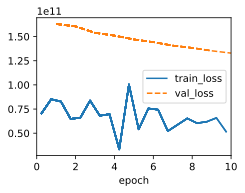

In [13]:
#treinando o modelo
# Prepara o conjunto de dados como TensorDataset
from torch.utils.data import TensorDataset, DataLoader
from d2l import torch as d2l

# Conjunto de treino e teste
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor) # Create test dataset as well

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64) # Create test loader

# Create a DataModule
class DataModule(d2l.DataModule):
    def __init__(self, train_loader, test_loader):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader = test_loader # Use test_loader as validation loader for this example

    def get_dataloader(self, train):
        if train:
            return self.train_loader
        else:
            return self.val_loader

data = DataModule(train_loader, test_loader)

# Treinamento
trainer.fit(model, data)

In [14]:
#avaliação do modelo
# Previsões no conjunto de teste
y_pred = model(X_test_tensor)

# Calcula MSE manualmente
mse_loss = nn.MSELoss()
mse = mse_loss(y_pred, y_test_tensor).item()
print(f"Erro quadrático médio (MSE) no teste: {mse:.2f}")

Erro quadrático médio (MSE) no teste: 135239049216.00


# **6.Visualização**

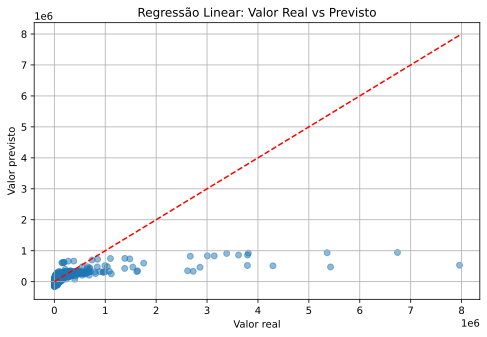

In [15]:
#comparar visualmente o valor real com a previsão:
import matplotlib.pyplot as plt

# Converte tensores para numpy
y_true = y_test_tensor.view(-1).detach().numpy()
y_pred_np = y_pred.view(-1).detach().numpy()

# Gráfico de dispersão
plt.figure(figsize=(8, 5))
plt.scatter(y_true, y_pred_np, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Valor real")
plt.ylabel("Valor previsto")
plt.title("Regressão Linear: Valor Real vs Previsto")
plt.grid(True)
plt.show()

# **1.Criando o modelo MLP**

In [24]:
class MLPRegressor(d2l.Module):
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Linear(X_train_tensor.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def loss(self, y_hat, y):
        return nn.MSELoss()(y_hat, y)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    # Add the forward method here
    def forward(self, X):
        return self.net(X)

# **2.Treinando Modelo**

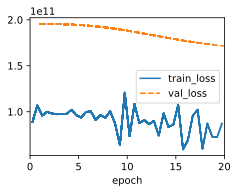

In [25]:
model_mlp = MLPRegressor(lr=0.001)
trainer_mlp = d2l.Trainer(max_epochs=20)

train_dataset_mlp = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset_mlp = TensorDataset(X_test_tensor, y_test_tensor) # Create test dataset as well

train_loader_mlp = DataLoader(train_dataset_mlp, batch_size=64, shuffle=True)
test_loader_mlp = DataLoader(test_dataset_mlp, batch_size=64) # Create test loader

# Create a DataModule for the MLP model
class DataModuleMLP(d2l.DataModule):
    def __init__(self, train_loader, test_loader):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader = test_loader # Use test_loader as validation loader for this example

    def get_dataloader(self, train):
        if train:
            return self.train_loader
        else:
            return self.val_loader

data_mlp = DataModuleMLP(train_loader_mlp, test_loader_mlp)


trainer_mlp.fit(model_mlp, data_mlp)

# **3.Avaliação o conjunto de teste**

In [26]:
y_pred_mlp = model_mlp(X_test_tensor)

mse_mlp = nn.MSELoss()(y_pred_mlp, y_test_tensor).item()
print(f"MSE (MLP): {mse_mlp:.2f}")

MSE (MLP): 174450950144.00


# **4. Visualização dos resultados**

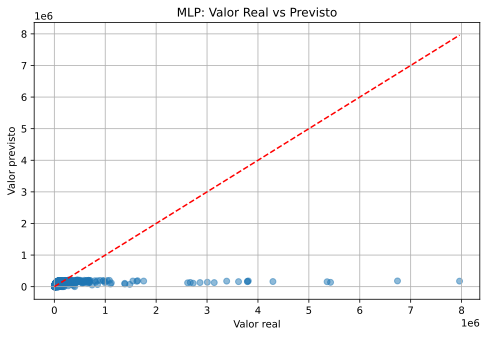

In [27]:
# Converte para numpy
y_true = y_test_tensor.view(-1).detach().numpy()
y_pred_np = y_pred_mlp.view(-1).detach().numpy()

plt.figure(figsize=(8, 5))
plt.scatter(y_true, y_pred_np, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Valor real")
plt.ylabel("Valor previsto")
plt.title("MLP: Valor Real vs Previsto")
plt.grid(True)
plt.show()

Vamos agora treinar a mesma MLP, mas prevendo log(preço) em vez do preço diretamente. Isso deve melhorar o aprendizado e a sensibilidade do modelo, especialmente para valores altos.

# **1. Transformar os targets com log1p**

In [28]:
# Aplica log1p para evitar problemas com valores zero
y_train_log_tensor = torch.log1p(y_train_tensor)
y_test_log_tensor = torch.log1p(y_test_tensor)

# **2. Reutilizar o modelo MLP, mas com novos targets**

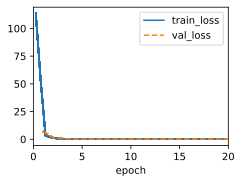

In [30]:
model_mlp_log = MLPRegressor(lr=0.001)
trainer_mlp_log = d2l.Trainer(max_epochs=20)

train_dataset_log = TensorDataset(X_train_tensor, y_train_log_tensor)
test_dataset_log = TensorDataset(X_test_tensor, y_test_log_tensor) # Create test dataset as well

train_loader_log = DataLoader(train_dataset_log, batch_size=64, shuffle=True)
test_loader_log = DataLoader(test_dataset_log, batch_size=64) # Create test loader

# Create a DataModule for the log-transformed data
class DataModuleLog(d2l.DataModule):
    def __init__(self, train_loader, test_loader):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader = test_loader # Use test_loader as validation loader for this example

    def get_dataloader(self, train):
        if train:
            return self.train_loader
        else:
            return self.val_loader

data_mlp_log = DataModuleLog(train_loader_log, test_loader_log)


trainer_mlp_log.fit(model_mlp_log, data_mlp_log)

# **3. Fazer a predição (e aplicar expm1 para voltar à escala original)**

In [31]:
y_pred_log = model_mlp_log(X_test_tensor)

# Retorna para escala real com expm1 (inverso de log1p)
y_pred_log_real = torch.expm1(y_pred_log)

# **4. Avaliar o desempenho (MSE real)**

In [32]:
mse_log = nn.MSELoss()(y_pred_log_real, y_test_tensor).item()
print(f"MSE (MLP com log transformado): {mse_log:.2f}")

MSE (MLP com log transformado): 67116023808.00


# **5.Visualização**

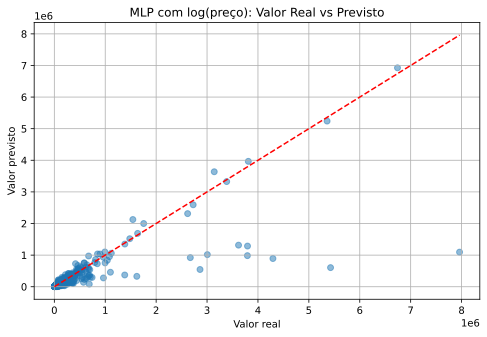

In [33]:
# Conversão para numpy
y_true = y_test_tensor.view(-1).detach().numpy()
y_pred_np = y_pred_log_real.view(-1).detach().numpy()

plt.figure(figsize=(8, 5))
plt.scatter(y_true, y_pred_np, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Valor real")
plt.ylabel("Valor previsto")
plt.title("MLP com log(preço): Valor Real vs Previsto")
plt.grid(True)
plt.show()